In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats.stats import pearsonr


C:\Users\Joshd\AppData\Local\Temp\ipykernel_20180\3746503147.py:7: DeprecationWarning: Please use `pearsonr` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import pearsonr


In [2]:
train = pd.read_csv(r"C:\Pycharm\House Prices ML\train.csv")
test = pd.read_csv(r"C:\Pycharm\House Prices ML\test.csv")

In [3]:
train.head()


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
all_data = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'],
                      test.loc[:,'MSSubClass':'SaleCondition']))

array([[<AxesSubplot: title={'center': 'price'}>,
        <AxesSubplot: title={'center': 'log(price + 1)'}>]], dtype=object)

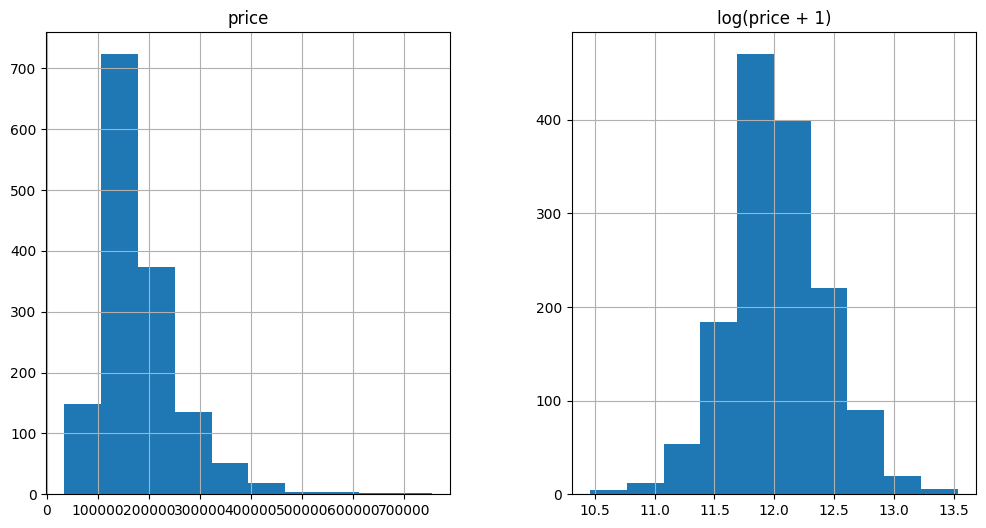

In [5]:
matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)
prices = pd.DataFrame({"price":train["SalePrice"], "log(price + 1)":np.log1p(train["SalePrice"])})
prices.hist()

In [6]:
from unicodedata import numeric
train["SalePrice"] = np.log1p(train["SalePrice"]) #Log transform the target
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index
skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna()))
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index
all_data[skewed_feats] = np.log1p(all_data[skewed_feats])

In [7]:
all_data = pd.get_dummies(all_data) #convert all categorical data into dummy variables 

In [8]:
all_data = all_data.fillna(all_data.mean()) #Filling all NA's with mean of each column

In [9]:
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score


In [10]:
#creating matrices for sklearn:
X_train = all_data[:train.shape[0]]
X_test = all_data[train.shape[0]:]
y = train.SalePrice


In [11]:
model_ridge = Ridge(0.1)
rmse= np.sqrt(-cross_val_score(Ridge(0.1), X_train, y, scoring="neg_mean_squared_error", cv = 5))
print("RMSE: ", rmse)
print("RMSE Average:", rmse.mean())


RMSE:  [0.12156718 0.14425787 0.1516712  0.11267361 0.15870705]
RMSE Average: 0.137775382771879


In [12]:
model_ridge.fit(X_train, y)
RidgePredictions = np.expm1(model_ridge.predict(X_test))
submission = pd.DataFrame({ 'Id': test.Id,
 'SalePrice': RidgePredictions })
submission.to_csv("submission.csv", index=False)


In [13]:
def rmse_cv(model):
 rmse= np.sqrt(-cross_val_score(model, X_train, y, scoring="neg_mean_squared_error", cv = 5))
 return(rmse)

Text(0, 0.5, 'rmse')

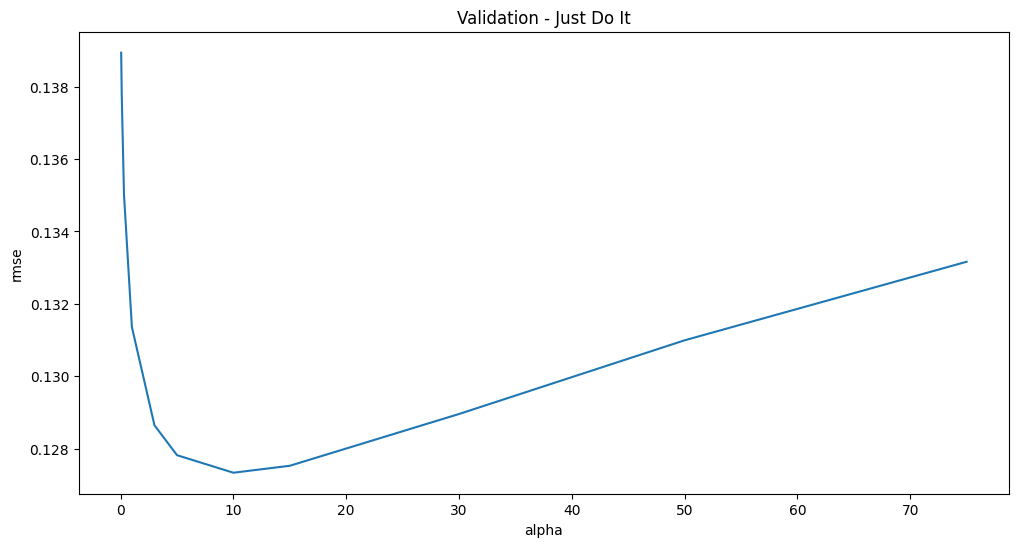

In [14]:
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
cv_ridge = [rmse_cv(Ridge(alpha=alpha)).mean() for alpha in alphas]
cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Validation - Just Do It")
plt.xlabel("alpha")
plt.ylabel("rmse")

In [15]:
print(cv_ridge.min())

0.12733734668670765


In [16]:
model_ridge = Ridge(10)
model_ridge.fit(X_train, y)
RidgePredictions = np.expm1(model_ridge.predict(X_test))
RidgeSubmission = pd.DataFrame({ 'Id': test.Id,
 'SalePrice': RidgePredictions })
RidgeSubmission.to_csv("RidgeSubmission.csv", index=False)

**The best score from a single ridge regression model with an alpha of 10 is 0.12479**

In [17]:
model_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005]).fit(X_train, y)
rmse_cv(model_lasso).mean()
lassoPredictions = np.expm1(model_lasso.predict(X_test))
LassoSubmission = pd.DataFrame({ 'Id': test.Id,
 'SalePrice': lassoPredictions })
LassoSubmission.to_csv("LassoSubmission.csv", index=False)

**The best score for a single lasso model is 0.12455**

<AxesSubplot: xlabel='Id', ylabel='SalePrice'>

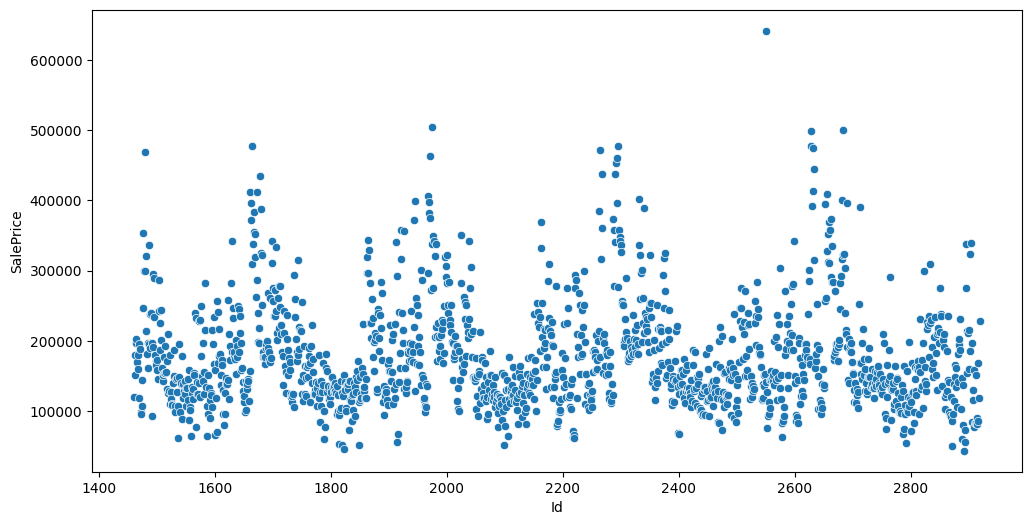

In [18]:
sns.scatterplot(x = LassoSubmission["Id"], y = LassoSubmission["SalePrice"])


In [19]:
import xgboost as xgb

In [20]:
dtrain = xgb.DMatrix(X_train, label = y)
dtest = xgb.DMatrix(X_test)
params = {"max_depth":2, "eta":0.1}
model = xgb.cv(params, dtrain, num_boost_round=500, early_stopping_rounds=100)


<AxesSubplot: >

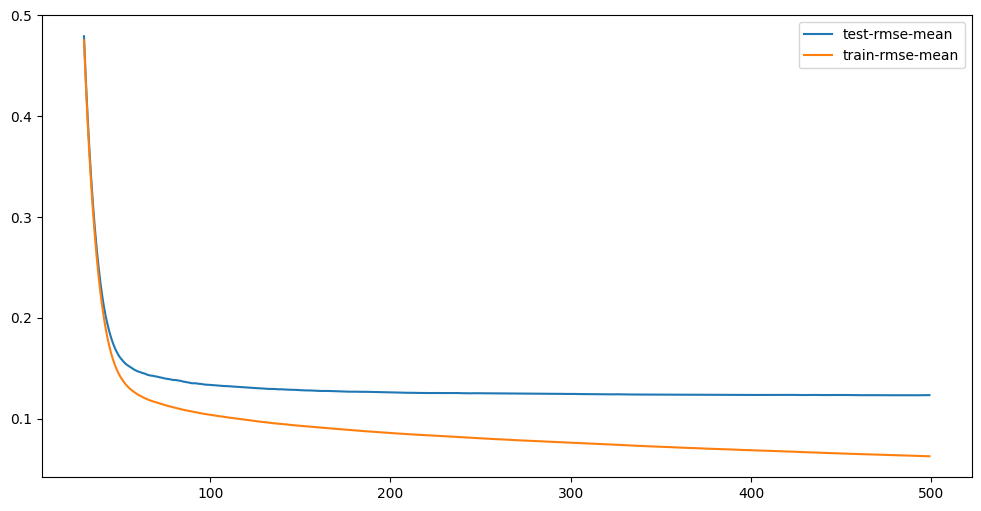

In [21]:
model.loc[30:,["test-rmse-mean", "train-rmse-mean"]].plot()

In [22]:
model_xgb = xgb.XGBRegressor(n_estimators=360, max_depth=2, learning_rate=0.1)
model_xgb.fit(X_train, y)
XGBPredictions = np.expm1(model_xgb.predict(X_test))
submission = pd.DataFrame({ 'Id': test.Id,
 'SalePrice': XGBPredictions })
submission.to_csv("submission.csv", index=False)

**A single XBGRegressor model scored a 0.13278**

In [23]:
Predictions = 0.7*lassoPredictions + 0.3*XGBPredictions
solution = pd.DataFrame({"id":test.Id, "SalePrice":Predictions})
solution.to_csv("ridge_sol.csv", index = False)

**After taking a weight combination of the Lasso and XGBRegressor model, the score recieved was 0.12299**
